In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import tqdm
import flax
import deluca.core
import matplotlib.pyplot as plt
from ilqr import iLQR
from deluca.envs import PlanarQuadrotor

In [3]:
def cost(x, u, sim):
    return 0.1 * (u - sim.goal_action) @ (u - sim.goal_action) + (x.arr - sim.goal_state) @ (x.arr - sim.goal_state)

env_true, env_sim = PlanarQuadrotor.create(wind=0.4), PlanarQuadrotor.create()
#Initial actions
U0 = jnp.tile(env_sim.goal_action, (env_sim.H, 1))
# Warm up with either file or iLQR
warmup_steps = 8
X, U, k, K, c = iLQR(env_sim, cost, U0, warmup_steps, verbose=False)

In [4]:
%%capture iLC_output
from ilc import iLC_closed
T = 40
iLC_result = iLC_closed(env_true, env_sim, cost, U, T, k, K, X, ref_alpha=0.2),

In [5]:
iLC_output()

iLC: t = -1, r = 1, c = 4487.193359375
iLC (closed+alpha=0.2): t = 0, r = 3, c = 4026.633544921875, alpha = 0.19999998807907104
iLC (closed+alpha=0.2): t = 1, r = 8, c = 3935.43310546875, alpha = 0.047878388315439224
iLC (closed+alpha=0.2): t = 2, r = 9, c = 3905.0654296875, alpha = 0.052666228264570236
iLC (closed+alpha=0.2): t = 3, r = 11, c = 3903.934814453125, alpha = 0.05266622453927994
iLC (closed+alpha=0.2): t = 4, r = 13, c = 3899.5615234375, alpha = 0.05266622081398964
iLC (closed+alpha=0.2): t = 5, r = 14, c = 3874.069091796875, alpha = 0.05793284252285957
iLC (closed+alpha=0.2): t = 6, r = 15, c = 3803.79931640625, alpha = 0.06372612714767456
iLC (closed+alpha=0.2): t = 7, r = 16, c = 3670.3173828125, alpha = 0.07009874284267426
iLC (closed+alpha=0.2): t = 8, r = 17, c = 3462.566162109375, alpha = 0.07710861414670944
iLC (closed+alpha=0.2): t = 9, r = 18, c = 3179.237548828125, alpha = 0.08481947332620621
iLC (closed+alpha=0.2): t = 10, r = 19, c = 2830.266845703125, alpha =

In [16]:
%%capture iGPC_output
from igpc import iGPC_closed
T = 40
iGPC_result = iGPC_closed(env_true, env_sim, cost, U, T, k, K, X, 'de', ref_alpha=0.2, lr=0.001)

In [17]:
iGPC_output()

iGPC: t = -1, r = 1, c = 4487.193359375
Trying alpha  0.22
iGPC: t = 0, r = 2, c = 4368.88037109375, alpha = 0.2199999988079071, lr = 0.001
Trying alpha  0.242
Trying alpha  0.21999998
Trying alpha  0.16528924
Trying alpha  0.102631606
iGPC: t = 1, r = 6, c = 4311.3662109375, alpha = 0.10263160616159439, lr = 0.001
Trying alpha  0.112894766
iGPC: t = 2, r = 7, c = 4286.97705078125, alpha = 0.11289476603269577, lr = 0.001
Trying alpha  0.12418424
iGPC: t = 3, r = 8, c = 4082.1669921875, alpha = 0.12418424338102341, lr = 0.001
Trying alpha  0.13660267
iGPC: t = 4, r = 9, c = 3625.74853515625, alpha = 0.13660266995429993, lr = 0.001
Trying alpha  0.15026294
iGPC: t = 5, r = 10, c = 2974.2626953125, alpha = 0.15026293694972992, lr = 0.001
Trying alpha  0.16528922
iGPC: t = 6, r = 11, c = 2248.27197265625, alpha = 0.16528922319412231, lr = 0.001
Trying alpha  0.18181814
iGPC: t = 7, r = 12, c = 1566.6405029296875, alpha = 0.1818181425333023, lr = 0.001
Trying alpha  0.19999996
iGPC: t = 8, 

In [18]:
import re

def postprocess(a):
    rs, vs = a
    newrs, newvs = [], []
    ref = 0
    for (i, (r, v)) in enumerate(zip(rs, vs)):
        r = int(r)
        if i == len(rs) - 1:
            newrs += [r]
            newvs += [v]
        else:
            next_r = int(rs[i + 1])
            newrs += list(range(r, next_r))
            newvs += [v for _ in range(r, next_r)]
    return newrs, newvs


def convert_to_dict(txt):
    z_pattern = f"(.*): t = -1, r = ([0-9]*), c = ([0-9.]*)"
    z_res = results = list(zip(*re.findall(z_pattern, txt)))
    zerocost = float(z_res[2][0])
    pattern = f"(.*): t = [0-9]*, r = ([0-9]*), c = ([0-9.]*)"
    results = list(zip(*re.findall(pattern, txt)))
    #     if len(results) > 0:
    #         results = results[0], list(map(float, results[1])), list(map(float, results[2]))
    #all_keys = list(set(results[0]))
    #results_dict = {}
    #for k in all_keys:
    #print(results)
    return [[0., 1.] + [float(r) for r in results[1]], [zerocost, zerocost] + [float(r) for r in results[2]]]

iLC_perf = postprocess(convert_to_dict(str(iLC_output.stdout)))
iGPC_perf = postprocess(convert_to_dict(str(iGPC_output.stdout)))

print(iLC_perf, iGPC_perf)

NameError: name 'iLC_output' is not defined

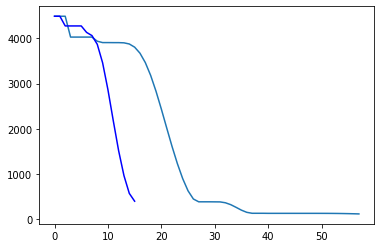

In [9]:
import matplotlib.pyplot as plt

plt.plot(iLC_perf[0], iLC_perf[1])
plt.plot(iGPC_perf[0], iGPC_perf[1], 'blue')